<a href="https://colab.research.google.com/github/teekaytai/cs4248-project/blob/ahiyer/%5BWI_LOCNESS%5D_Final_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENERAL

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
test_path = '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.json'
train_path = '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/train.json'
val_path = '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/val.json'

In [ ]:
import pandas as pd

In [ ]:
# Tokenize senteces with simple fuction
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

In [ ]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from collections import namedtuple

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import spacy

In [ ]:
import regex as re

# TRANSFORMERS

## TRANSFORMERS (BART) : No Context

> NO CONTEXT



In [ ]:
'''
Baseline
Input: Error Sentences
Output: Corrected Sentences
'''
import spacy
import torch
from transformers import BartModel, BartForConditionalGeneration, BartTokenizerFast
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

# Configs
BART_MODEL = 'gotutiyan/gec-bart-base'
MAX_SOURCE_LENGTH = 240
MAX_TARGET_LENGTH = 240
NUM_EPOCHS = 10
# Hugging face documentation reccomends 1e-4 or 3e-4 for T5
LEARNING_RATE = 3e-4
NUM_BEAMS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BartTokenizerFast.from_pretrained(BART_MODEL)
nlp = spacy.load("en_core_web_sm")
spacy_tokenizer = nlp.tokenizer

def tokenize_source_sentences(sentences):
    return tokenizer(
        sentences,
        padding = 'max_length',
        max_length = MAX_SOURCE_LENGTH,
        truncation = True,
        return_tensors = "pt",
    ).to(device)

def tokenize_target_sentences(sentences):
    tokenized = tokenizer(
        sentences,
        padding = 'max_length',
        max_length = MAX_TARGET_LENGTH,
        truncation = True,
        return_tensors="pt",
    ).to(device)
    # Replace padding token ids of the labels by -100 so it's ignored by the loss
    ids = tokenized.input_ids
    ids[ids == tokenizer.pad_token_id] = -100
    tokenized.input_ids = ids
    return tokenized

def preprocess_dataset(dataset, source_column_name, target_column_name):
    tokenized_source = tokenize_source_sentences(dataset[source_column_name])
    tokenized_target = tokenize_target_sentences(dataset[target_column_name])
    input = {}
    input['input_ids'] = tokenized_source['input_ids']
    input['attention_mask'] = tokenized_source['attention_mask']
    input['labels'] = tokenized_target['input_ids']
    return input

def train(train_dataset, eval_dataset, output_dir):
    model = BartForConditionalGeneration.from_pretrained(BART_MODEL)
    model.to(device)

    training_args = TrainingArguments(
        output_dir = output_dir,
        num_train_epochs = NUM_EPOCHS,
        evaluation_strategy = 'steps',
        eval_steps = 500,
        save_steps = 500,
        learning_rate = LEARNING_RATE,
        load_best_model_at_end = True,
        save_total_limit = 2,
    )

    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset
    )

    trainer.train()

def generate(model_path, dataset):
    model = BartForConditionalGeneration.from_pretrained(model_path)
    model.to(device)

    generated_sentences = []

    for sample in dataset:
        original = sample['original']
        tokenized = tokenize_source_sentences([original])
        generated = model.generate(
            tokenized.input_ids,
            max_length = MAX_TARGET_LENGTH,
            num_beams = NUM_BEAMS,
            early_stopping=True
        )
        generated_sentence = tokenizer.decode(
            generated[0],
            skip_special_tokens=True,
        )
        # Retokenize sentence using spacy to restore correct spacing between tokens
        # for accurate error correction score calculation
        generated_sentence = ' '.join(tok.text for tok in spacy_tokenizer(generated_sentence))
        generated_sentences.append(generated_sentence)

    return generated_sentences

def get_model(path):
    model = BartForConditionalGeneration.from_pretrained(path)
    model.to(device)

    return model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.0 MB/s eta 0:00:00


In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
from datasets import load_dataset

dataset_train = load_dataset('json', data_files=train_path, split='train')
dataset_eval = load_dataset('json', data_files=val_path, split='train')

preprocessed_train = dataset_train.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs={"source_column_name": "original", "target_column_name": "corrected"}
)
preprocessed_eval = dataset_eval.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs={"source_column_name": "original", "target_column_name": "corrected"}
)

train(preprocessed_train, preprocessed_eval, 'outputs/model_sentence_2')

NameError: name 'train_path' is not defined

In [ ]:
! pip install errant

In [ ]:
!zip -r /content/outputs.zip /content/outputs

In [ ]:
from google.colab import files
files.download("/content/outputs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import errant
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import namedtuple

NOOP_EDIT = 'A -1 -1|||noop|||-NONE-|||REQUIRED|||-NONE-|||0'
nlp = spacy.load("en_core_web_sm")
annotator = errant.load('en', nlp)

def generate_m2(input_sentences, output_sentences, output_path):
    with open(output_path, 'w') as f:
        for input, output in zip(input_sentences, output_sentences):
            edits = annotator.annotate(annotator.parse(input), annotator.parse(output))
            print('S', input, file=f)
            if not edits:
                print(NOOP_EDIT, file=f)
            for edit in edits:
                print(edit.to_m2(), file=f)
            print(file=f)  # Blank divider line



EDIT_OPS = {'M': 'Missing', 'U': 'Unnecessary', 'R': 'Replacement'}
NOOP_EDIT_TYPE = 'noop'
UNK_EDIT_TYPE = 'UNK'
EDIT_TYPES = [
    'ADJ', 'ADJ:FORM', 'ADV', 'CONJ', 'CONTR', 'DET', 'MORPH',
    'NOUN', 'NOUN:INFL', 'NOUN:NUM', 'NOUN:POSS',
    'ORTH', 'OTHER', 'PART', 'PREP', 'PRON', 'PUNCT', 'SPELL',
    'VERB', 'VERB:FORM', 'VERB:INFL', 'VERB:SVA', 'VERB:TENSE', 'WO',
]

Edit = namedtuple('Edit', ['span', 'code', 'correction'])

def load_edits(m2_file_path):
    edits = []
    with open(m2_file_path, 'r') as f:
        for group in f.read().split('\n\n'):
            if not group:
                continue
            sentence, *sent_edits = group.split('\n')
            edits.append([Edit(*e[2:].split('|||')[:3]) for e in sent_edits])
    return edits

def create_error_count_df(gold_edits, output_edits):
    rows = [*EDIT_OPS.values(), *EDIT_TYPES, NOOP_EDIT_TYPE, UNK_EDIT_TYPE]
    df = pd.DataFrame(0, index=rows, columns=['TP', 'FP', 'FN'])
    for gold_sent_edits, output_sent_edits in zip(gold_edits, output_edits):
        gold_set = set(gold_sent_edits)
        out_set = set(output_sent_edits)
        classified_edits = {
            'TP': gold_set & out_set,
            'FP': out_set - gold_set,
            'FN': gold_set - out_set
        }
        for outcome, edits in classified_edits.items():
            for edit in edits:
                if edit.code in (NOOP_EDIT_TYPE, UNK_EDIT_TYPE):
                    df.loc[edit.code, outcome] += 1
                else:
                    op, type_ = edit.code.split(':', maxsplit=1)
                    df.loc[EDIT_OPS[op], outcome] += 1
                    df.loc[type_, outcome] += 1
    df['P'] = df['TP'] / (df['TP'] + df['FP'])
    df['R'] = df['TP'] / (df['TP'] + df['FN'])
    df['F0.5'] = (1 + 0.5**2) * ((df['P'] * df['R']) / (0.5**2 * df['P'] + df['R']))
    return df

def analyze_error_types(actual_path, predicted_path):
    gold_edits = load_edits(actual_path)
    output_edits = load_edits(predicted_path)
    error_df = create_error_count_df(gold_edits, output_edits)
    print(error_df)
    sns.heatmap(error_df[['P', 'R', 'F0.5']], vmin=0.0, vmax=1.0, cmap='Reds', annot=True, yticklabels=True)
    plt.show()

def analyze_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


139,420,416 total parameters.
139,420,416 training parameters.
               TP    FP    FN         P         R      F0.5
Missing       617   603  1392  0.505738  0.307118  0.447815
Unnecessary   179   382   600  0.319073  0.229782  0.296064
Replacement   869  3029  3797  0.222935  0.186241  0.214483
ADJ             6   147   113  0.039216  0.050420  0.041040
ADJ:FORM        3     0     8  1.000000  0.272727  0.652174
ADV             8    71   115  0.101266  0.065041  0.091116
CONJ            2     9    46  0.181818  0.041667  0.108696
CONTR           9    11    21  0.450000  0.300000  0.409091
DET           220   283   588  0.437376  0.272277  0.390071
MORPH          20    76   159  0.208333  0.111732  0.177620
NOUN           25   929   319  0.026205  0.072674  0.030048
NOUN:INFL       1     1     4  0.500000  0.200000  0.384615
NOUN:NUM       76   117   155  0.393782  0.329004  0.378863
NOUN:POSS      10    19    50  0.344828  0.166667  0.284091
ORTH          145   174   200  0.4545

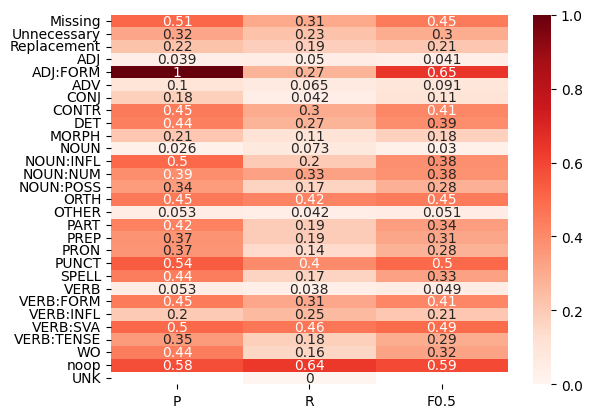

In [ ]:
model_path = 'outputs/model_sentence_2/checkpoint-35000'

analyze_params(get_model(model_path))

dataset_test = load_dataset('json', data_files=test_path, split='train')
generated_sentences = generate(model_path, dataset_test)

generate_m2(dataset_test['original'], generated_sentences, model_path + '/gen.m2')

analyze_error_types('/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2', model_path + '/gen.m2')

In [ ]:
CUSTOM_TESTS = [
    ['She saw a cat.', 'He screams out loud.'],  # PRON, VERB:TENSE
    ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.'],  # PRON
    ['The Millennium Prize Problems are seven very complex mathematical problems.', 'No one has solved it to this day.'],
    ['Car crashes are easily preventable.', 'Most cases occurred because the driver was careless.'],  # VERB:TENSE
    ['A study was done on 1000 car crashes.', 'Most cases occur because the driver is careless.'],
    ["If he thinks about it more, I'm sure he'll figure something out.", 'The right idea eventually came to him.'],  # VERB:TENSE
    ['The right idea will eventually come to him.', 'Many weeks of effort finally paid off.'],
    ['Everyone knows that cats are adorable.', 'But they make for great companions.'],  # CONJ
    ['Cats can be annoying at times.', 'And they make for great companions.'],
    ['I visit the apple store frequently.', "I'm always eager to check out the latest phone."],  # ORTH
    ['I visit the apple store frequently.', 'Fruit works great as a snack.'],
    ['Tom told his sister there was a spider in her hair.', 'Cried out in alarm.'],  # PRON
    ['There have been complaints about long queues in the canteens.', "I'm looking them now."],  # PREP
    ["I lost my earphones earlier.", "I'm looking them now."]
]

def get_custom_tests():
    dataset = []
    for para in CUSTOM_TESTS:
        for pos, sentence in enumerate(para):
            dataset.append({
                "original": sentence,
                "pos": pos,
                "paragraph": para
            })
    return dataset

In [ ]:
from datasets import Dataset

custom_tests = get_custom_tests()
print(custom_tests)
dataset_test = Dataset.from_list(custom_tests)

model_path = 'outputs/model_sentence_2/checkpoint-35000'
generated_sentences = generate(model_path, dataset_test)

with open(model_path + '/custom.txt', 'w') as f:
    for line in generated_sentences:
        f.write(f"{line}\n")

[{'original': 'She saw a cat.', 'pos': 0, 'paragraph': ['She saw a cat.', 'He screams out loud.']}, {'original': 'He screams out loud.', 'pos': 1, 'paragraph': ['She saw a cat.', 'He screams out loud.']}, {'original': 'The P versus NP problem is an unsolved problem in computer science.', 'pos': 0, 'paragraph': ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.']}, {'original': 'No one has solved them to this day.', 'pos': 1, 'paragraph': ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.']}, {'original': 'The Millennium Prize Problems are seven very complex mathematical problems.', 'pos': 0, 'paragraph': ['The Millennium Prize Problems are seven very complex mathematical problems.', 'No one has solved it to this day.']}, {'original': 'No one has solved it to this day.', 'pos': 1, 'paragraph': ['The Millennium Prize Problems are seven very complex mathematical problems.', 

## TRANSFORMERS (BART) : Sentence Flank

> SENTENCE FLANK



> Note that the parameters can be changed and finetuned as needed. For consistency's sake, we keep the same. Moreover, the 0/1, 1/0, 1/1 experiments are all done in this section by changing the relevant variables

In [ ]:
'''
Adding pre/post k sentences to the target sentence
Input: Error sentence + k pre + j post
Output: Corrected sentence
'''

import spacy
import torch
from transformers import BartModel, BartForConditionalGeneration, BartTokenizerFast
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

# Configs
BART_MODEL = 'gotutiyan/gec-bart-base'
MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 240
NUM_EPOCHS = 7
# Hugging face documentation reccomends 1e-4 or 3e-4 for T5
LEARNING_RATE = 3e-4
NUM_BEAMS = 5
CONCAT_PARA_TOKEN = ' <cct> '

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BartTokenizerFast.from_pretrained(BART_MODEL)
nlp = spacy.load("en_core_web_sm")
spacy_tokenizer = nlp.tokenizer

def tokenize_source_sentences(sentences, paragraphs, sentence_positions, prec_range, post_range):
    concatenated_sentences = []
    for sentence, para, pos in zip(sentences, paragraphs, sentence_positions):
        para_len = len(para)
        concatenated = CONCAT_PARA_TOKEN.join(para[max(pos - prec_range, 0) : min(pos + post_range + 1, para_len)])
        concatenated_sentences.append(concatenated)

    return tokenizer(
        sentences,
        padding = 'max_length',
        max_length = MAX_SOURCE_LENGTH,
        truncation = True,
        return_tensors = "pt",
    ).to(device)

def tokenize_target_sentences(sentences):
    tokenized = tokenizer(
        sentences,
        padding = 'max_length',
        max_length = MAX_TARGET_LENGTH,
        truncation = True,
        return_tensors="pt",
    ).to(device)
    # Replace padding token ids of the labels by -100 so it's ignored by the loss
    ids = tokenized.input_ids
    ids[ids == tokenizer.pad_token_id] = -100
    tokenized.input_ids = ids
    return tokenized

def preprocess_dataset(dataset, source_column_name, target_column_name, para_column_name, pos_column_name, prec_range, post_range):
    tokenized_source = tokenize_source_sentences(dataset[source_column_name], dataset[para_column_name], dataset[pos_column_name], prec_range, post_range)
    tokenized_target = tokenize_target_sentences(dataset[target_column_name])
    input = {}
    input['input_ids'] = tokenized_source['input_ids']
    input['attention_mask'] = tokenized_source['attention_mask']
    input['labels'] = tokenized_target['input_ids']
    return input

def train(train_dataset, eval_dataset, output_dir):
    model = BartForConditionalGeneration.from_pretrained(BART_MODEL)
    model.to(device)

    training_args = TrainingArguments(
        output_dir = output_dir,
        num_train_epochs = NUM_EPOCHS,
        evaluation_strategy = 'steps',
        eval_steps = 500,
        save_steps = 500,
        learning_rate = LEARNING_RATE,
        load_best_model_at_end = True,
        save_total_limit = 2,
    )

    trainer = Trainer(
        model = model,
        args = training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset
    )

    trainer.train()

def generate(model_path, dataset, prec_range, post_range):
    model = BartForConditionalGeneration.from_pretrained(model_path)
    model.to(device)

    generated_sentences = []
    i = 1

    for sample in dataset:
        print(i)
        i+=1
        original = sample['original']
        para = sample['paragraph']
        pos = sample['pos']
        tokenized = tokenize_source_sentences([original], [para], [pos], prec_range, post_range)
        generated = model.generate(
            tokenized.input_ids,
            max_length = MAX_TARGET_LENGTH,
            num_beams = NUM_BEAMS,
            early_stopping=True
        )
        generated_sentence = tokenizer.decode(
            generated[0],
            skip_special_tokens=True,
        )
        # Retokenize sentence using spacy to restore correct spacing between tokens
        # for accurate error correction score calculation
        generated_sentence = ' '.join(tok.text for tok in spacy_tokenizer(generated_sentence))
        generated_sentences.append(generated_sentence)

    return generated_sentences

def get_model(path):
    model = BartForConditionalGeneration.from_pretrained(path)
    model.to(device)

    return model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset_train = load_dataset('json', data_files=train_path, split='train')
dataset_eval = load_dataset('json', data_files=val_path, split='train')

dataset_kwargs = {
        "source_column_name": "original",
        "target_column_name": "corrected",
        "para_column_name": "paragraph",
        "pos_column_name": "pos",
        "prec_range": 1,
        "post_range": 0,
        }

preprocessed_train = dataset_train.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs=dataset_kwargs
)
preprocessed_eval = dataset_eval.map(
    preprocess_dataset,
    batched=True,
    fn_kwargs=dataset_kwargs
)

train(preprocessed_train, preprocessed_eval, 'outputs_sf/model_sentence_append_source/1_1')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/28066 [00:00<?, ? examples/s]

Map:   0%|          | 0/6996 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/558M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss
500,0.695700,0.600607
1000,0.736300,0.624406
1500,0.716900,0.640475
2000,0.723400,0.597944
2500,0.708100,0.610530
3000,0.688800,0.656329
3500,0.691200,0.603437
4000,0.528500,0.625975
4500,0.531900,0.625498
5000,0.530400,0.604618


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

KeyboardInterrupt: 

In [ ]:
!zip -r /content/outputs_sf.zip /content/outputs_sf

  adding: content/outputs/ (stored 0%)
  adding: content/outputs/model_sentence_2/ (stored 0%)
  adding: content/outputs/model_sentence_2/runs/ (stored 0%)
  adding: content/outputs/model_sentence_2/runs/Apr14_18-50-07_2a7cb1f78443/ (stored 0%)
  adding: content/outputs/model_sentence_2/runs/Apr14_18-50-07_2a7cb1f78443/events.out.tfevents.1713120607.2a7cb1f78443.12874.0 (deflated 69%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/ (stored 0%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/generation_config.json (deflated 47%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/optimizer.pt (deflated 7%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/config.json (deflated 64%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/trainer_state.json (deflated 82%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/rng_state.pth (deflated 25%)
  adding: content/outputs/model_sentence_2/checkpoint-35000/scheduler.pt (deflated 5

In [ ]:
from google.colab import files
files.download("/content/outputs_sf.zip")

In [ ]:
! pip install errant

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 27.7 MB/s eta 0:00:00


In [ ]:
import errant
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import namedtuple

NOOP_EDIT = 'A -1 -1|||noop|||-NONE-|||REQUIRED|||-NONE-|||0'
nlp = spacy.load("en_core_web_sm")
annotator = errant.load('en', nlp)

def generate_m2(input_sentences, output_sentences, output_path):
    with open(output_path, 'w') as f:
        for input, output in zip(input_sentences, output_sentences):
            edits = annotator.annotate(annotator.parse(input), annotator.parse(output))
            print('S', input, file=f)
            if not edits:
                print(NOOP_EDIT, file=f)
            for edit in edits:
                print(edit.to_m2(), file=f)
            print(file=f)  # Blank divider line



EDIT_OPS = {'M': 'Missing', 'U': 'Unnecessary', 'R': 'Replacement'}
NOOP_EDIT_TYPE = 'noop'
UNK_EDIT_TYPE = 'UNK'
EDIT_TYPES = [
    'ADJ', 'ADJ:FORM', 'ADV', 'CONJ', 'CONTR', 'DET', 'MORPH',
    'NOUN', 'NOUN:INFL', 'NOUN:NUM', 'NOUN:POSS',
    'ORTH', 'OTHER', 'PART', 'PREP', 'PRON', 'PUNCT', 'SPELL',
    'VERB', 'VERB:FORM', 'VERB:INFL', 'VERB:SVA', 'VERB:TENSE', 'WO',
]

Edit = namedtuple('Edit', ['span', 'code', 'correction'])

def load_edits(m2_file_path):
    edits = []
    with open(m2_file_path, 'r') as f:
        for group in f.read().split('\n\n'):
            if not group:
                continue
            sentence, *sent_edits = group.split('\n')
            edits.append([Edit(*e[2:].split('|||')[:3]) for e in sent_edits])
    return edits

def create_error_count_df(gold_edits, output_edits):
    rows = [*EDIT_OPS.values(), *EDIT_TYPES, NOOP_EDIT_TYPE, UNK_EDIT_TYPE]
    df = pd.DataFrame(0, index=rows, columns=['TP', 'FP', 'FN'])
    for gold_sent_edits, output_sent_edits in zip(gold_edits, output_edits):
        gold_set = set(gold_sent_edits)
        out_set = set(output_sent_edits)
        classified_edits = {
            'TP': gold_set & out_set,
            'FP': out_set - gold_set,
            'FN': gold_set - out_set
        }
        for outcome, edits in classified_edits.items():
            for edit in edits:
                if edit.code in (NOOP_EDIT_TYPE, UNK_EDIT_TYPE):
                    df.loc[edit.code, outcome] += 1
                else:
                    op, type_ = edit.code.split(':', maxsplit=1)
                    df.loc[EDIT_OPS[op], outcome] += 1
                    df.loc[type_, outcome] += 1
    df['P'] = df['TP'] / (df['TP'] + df['FP'])
    df['R'] = df['TP'] / (df['TP'] + df['FN'])
    df['F0.5'] = (1 + 0.5**2) * ((df['P'] * df['R']) / (0.5**2 * df['P'] + df['R']))
    return df

def analyze_error_types(actual_path, predicted_path):
    gold_edits = load_edits(actual_path)
    output_edits = load_edits(predicted_path)
    error_df = create_error_count_df(gold_edits, output_edits)
    print(error_df)
    sns.heatmap(error_df[['P', 'R', 'F0.5']], vmin=0.0, vmax=1.0, cmap='Reds', annot=True, yticklabels=True)
    plt.show()

def analyze_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
x = load_dataset('json', data_files=test_path, split='train')
print(x.shape)

In [ ]:
from datasets import load_dataset

model_path = 'outputs_sf/model_sentence_append_source/1_1/checkpoint-7000'

analyze_params(get_model(model_path))

dataset_test = load_dataset('json', data_files=test_path, split='train')
generated_sentences = generate(
    model_path,
    dataset_test,
    1,
    0
)

generate_m2(dataset_test['original'], generated_sentences, model_path + '/gen.m2')

analyze_error_types('/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2', model_path + '/gen.m2')

139,420,416 total parameters.
139,420,416 training parameters.


Generating train split: 0 examples [00:00, ? examples/s]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


               TP    FP    FN         P         R      F0.5
Missing       500   591  1509  0.458295  0.248880  0.392280
Unnecessary   127   475   652  0.210963  0.163030  0.199247
Replacement   689  2510  3977  0.215380  0.147664  0.197286
ADJ             6   164   113  0.035294  0.050420  0.037547
ADJ:FORM        2     2     9  0.500000  0.181818  0.370370
ADV             4    77   119  0.049383  0.032520  0.044743
CONJ            1     9    47  0.100000  0.020833  0.056818
CONTR           5    10    25  0.333333  0.166667  0.277778
DET           166   334   642  0.332000  0.205446  0.295584
MORPH          27    99   152  0.214286  0.150838  0.197657
NOUN           19   663   325  0.027859  0.055233  0.030924
NOUN:INFL       1     1     4  0.500000  0.200000  0.384615
NOUN:NUM       64   167   167  0.277056  0.277056  0.277056
NOUN:POSS       3    10    57  0.230769  0.050000  0.133929
ORTH          142   197   203  0.418879  0.411594  0.417402
OTHER          20   612   831  0.031646 

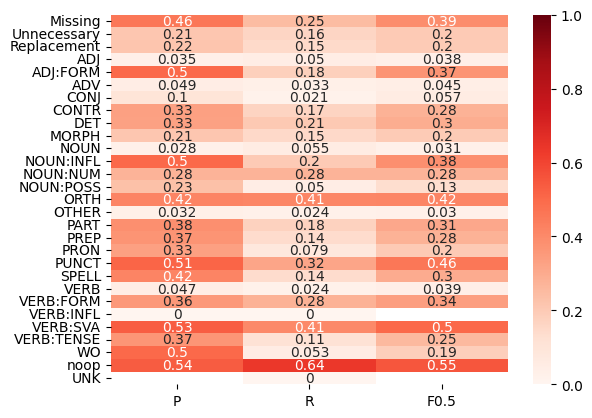

In [ ]:
analyze_error_types('/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2', model_path + '/gen.m2')

In [ ]:
!errant_compare -hyp "/content/outputs_sf/model_sentence_append_source/1_1/checkpoint-7000/gen.m2" -ref  '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2'


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
1319	3573	6135	0.2696	0.177	0.2441



In [ ]:
!errant_compare -hyp "/content/bart_simple_gen.m2" -ref  '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2'


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
1666	4013	5788	0.2934	0.2235	0.2761



In [ ]:
!errant_compare -hyp "/content/bart_sf8500_10_gen.m2" -ref  '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2'


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
1239	3906	6215	0.2408	0.1662	0.221



In [ ]:
CUSTOM_TESTS = [
    ['She saw a cat.', 'He screams out loud.'],  # PRON, VERB:TENSE
    ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.'],  # PRON
    ['The Millennium Prize Problems are seven very complex mathematical problems.', 'No one has solved it to this day.'],
    ['Car crashes are easily preventable.', 'Most cases occurred because the driver was careless.'],  # VERB:TENSE
    ['A study was done on 1000 car crashes.', 'Most cases occur because the driver is careless.'],
    ["If he thinks about it more, I'm sure he'll figure something out.", 'The right idea eventually came to him.'],  # VERB:TENSE
    ['The right idea will eventually come to him.', 'Many weeks of effort finally paid off.'],
    ['Everyone knows that cats are adorable.', 'But they make for great companions.'],  # CONJ
    ['Cats can be annoying at times.', 'And they make for great companions.'],
    ['I visit the apple store frequently.', "I'm always eager to check out the latest phone."],  # ORTH
    ['I visit the apple store frequently.', 'Fruit works great as a snack.'],
    ['Tom told his sister there was a spider in her hair.', 'Cried out in alarm.'],  # PRON
    ['There have been complaints about long queues in the canteens.', "I'm looking them now."],  # PREP
    ["I lost my earphones earlier.", "I'm looking them now."]
]

def get_custom_tests():
    dataset = []
    for para in CUSTOM_TESTS:
        for pos, sentence in enumerate(para):
            dataset.append({
                "original": sentence,
                "pos": pos,
                "paragraph": para
            })
    return dataset

In [ ]:
from datasets import Dataset

custom_tests = get_custom_tests()
dataset_test = Dataset.from_list(custom_tests)

model_path = 'outputs_sf/model_sentence_append_source/1_1/checkpoint-7000'
generated_sentences = generate(model_path, dataset_test, 1, 0)

with open(model_path + '/custom.txt', 'w') as f:
    for line in generated_sentences:
        f.write(f"{line}\n")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


In [ ]:
from google.colab import files
files.download('/content/outputs_sf/model_sentence_append_source/1_1/checkpoint-7000/gen.m2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download('/content/outputs_sf/model_sentence_append_source/1_1/checkpoint-7000/custom.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EXPERIMENTS

## TRANSFORMER PERFORMANCE RAW

In [ ]:
'''
Adding pre/post k sentences to the target sentence
Input: Error sentence + k pre + j post
Output: Corrected sentence
'''

import spacy
import torch
from transformers import BartModel, BartForConditionalGeneration, BartTokenizerFast
from transformers import T5Tokenizer, T5ForConditionalGeneration, TrainingArguments, Trainer

# Configs
BART_MODEL = 'gotutiyan/gec-bart-base'
MAX_SOURCE_LENGTH = 512
MAX_TARGET_LENGTH = 240
NUM_EPOCHS = 7
# Hugging face documentation reccomends 1e-4 or 3e-4 for T5
LEARNING_RATE = 3e-4
NUM_BEAMS = 5
CONCAT_PARA_TOKEN = ' <cct> '

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BartTokenizerFast.from_pretrained(BART_MODEL)
nlp = spacy.load("en_core_web_sm")
spacy_tokenizer = nlp.tokenizer

def tokenize_target_sentences(sentences):
    tokenized = tokenizer(
        sentences,
        padding = 'max_length',
        max_length = MAX_TARGET_LENGTH,
        truncation = True,
        return_tensors="pt",
    ).to(device)
    # Replace padding token ids of the labels by -100 so it's ignored by the loss
    ids = tokenized.input_ids
    ids[ids == tokenizer.pad_token_id] = -100
    tokenized.input_ids = ids
    return tokenized

def preprocess_dataset(dataset, source_column_name, target_column_name, para_column_name, pos_column_name, prec_range, post_range):
    tokenized_source = tokenize_source_sentences(dataset[source_column_name], dataset[para_column_name], dataset[pos_column_name], prec_range, post_range)
    tokenized_target = tokenize_target_sentences(dataset[target_column_name])
    input = {}
    input['input_ids'] = tokenized_source['input_ids']
    input['attention_mask'] = tokenized_source['attention_mask']
    input['labels'] = tokenized_target['input_ids']
    return input

def generate(model_path, dataset, prec_range, post_range):
    model = BartForConditionalGeneration.from_pretrained(model_path)
    model.to(device)

    generated_sentences = []
    i = 1

    for sample in dataset:
        print(i)
        i+=1
        original = sample['original']
        para = sample['paragraph']
        pos = sample['pos']
        tokenized = tokenize_source_sentences([original], [para], [pos], prec_range, post_range)
        generated = model.generate(
            tokenized.input_ids,
            max_length = MAX_TARGET_LENGTH,
            num_beams = NUM_BEAMS,
            early_stopping=True
        )
        generated_sentence = tokenizer.decode(
            generated[0],
            skip_special_tokens=True,
        )
        # Retokenize sentence using spacy to restore correct spacing between tokens
        # for accurate error correction score calculation
        generated_sentence = ' '.join(tok.text for tok in spacy_tokenizer(generated_sentence))
        generated_sentences.append(generated_sentence)

    return generated_sentences

def get_model(path):
    model = BartForConditionalGeneration.from_pretrained(path)
    model.to(device)

    return model

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

In [ ]:
from transformers import pipeline

# Initialize the text-generation pipeline for text correction
corrector = pipeline("text2text-generation", "pszemraj/bart-base-grammar-synthesis")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
dataset_test = load_dataset('json', data_files=test_path, split='train')
def generated_sentences():
  i = 0
  for text in dataset_test:
    if i > 3:
      break
    else:
      print(corrector(text["original"])[0]["generated_text"])
      i+=1

In [ ]:
generated_sentences()

It's difficult to answer the question "What are you going to do in the future? " if the only one who has to know it is in two minds.
When I was younger, I used to say that I wanted to be a teacher, a salesman, and even a butcher.
I do n't know why.
I would like to study psychology because one day I would open my own psychology office and help people.


In [ ]:
generated_sentences_raw = np.array([])

In [ ]:
i = 1
for text in dataset_test:
  if i < 3:
    print(generated_sentences_raw)
    generated_sentences_raw = np.append(generated_sentences_raw, corrector(text["original"])[0]["generated_text"])
    i += 1
  else:
    print(i)
    i += 1
    org = text["original"]
    generated_sentences_raw = np.append(generated_sentences_raw, corrector(text["original"])[0]["generated_text"])


[]
['It\'s difficult to answer the question "What are you going to do in the future? " if the only one who has to know it is in two minds.']
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [ ]:
from datasets import load_dataset

model_path = 'pszemraj/bart-base-grammar-synthesis'

analyze_params(get_model(model_path))

dataset_test = load_dataset('json', data_files=test_path, split='train')
def generated_sentences():
  for text in dataset_text:
    print(text)

generate_m2(dataset_test['original'], generated_sentences, '/gen.m2')

analyze_error_types('/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2', '/gen.m2')

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

KeyboardInterrupt: 

## BiLSTM Grammar Correction Experiements (Archived)

Credit:

https://medium.com/geekculture/neural-machine-translation-using-seq2seq-model-with-attention-9faea357d70b

https://shreelakshmigp1995.medium.com/grammatical-error-correction-using-deep-learning-c36824de184

https://colab.research.google.com/drive/1XrjPL3O_szhahYZW0z9yhCl9qvIcJJYW

https://suraj1997lodh.medium.com/grammar-error-handling-and-correction-with-dataset-creation-e446fa6863b8

https://medium.com/analytics-vidhya/grammatical-error-correction-using-neural-networks-aaf3e9fc91c

## BILSTM NO CONTEXT


In [ ]:
train_df = pd.read_json(train_path)
val_df = pd.read_json(val_path)
test_df = pd.read_json(test_path)

In [ ]:
combined_train_val_df = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
# adding special tokens
combined_train_val_df['corrected'] =combined_train_val_df.corrected.apply(lambda x: 'sos '+ x + ' eos')

# Convert into list of sentence we need list to pass in tokenizer
org_texts = combined_train_val_df.original.to_list()
cor_texts = combined_train_val_df.corrected.to_list()

In [ ]:
def tokenize_sent(text):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)

In [ ]:
# Tokenize
org_tokenizer, org_encoded= tokenize_sent(text= org_texts)
cor_tokenizer, cor_encoded= tokenize_sent(text= cor_texts)

# Original Word --> index dictionary
org_index_word = org_tokenizer.index_word

# Orignal Index --> word dictionary
org_word_index= org_tokenizer.word_index

# size of Original vocabulary for encoder input
# For zero padding we have to add +1 in size
ORG_VOCAB_SIZE = len(org_tokenizer.word_counts)+1

# Corrected Word --> index dict
cor_word_index= cor_tokenizer.word_index

# Corrected Index --> word dict
cor_index_word = cor_tokenizer.index_word

# Cor vocab size for decoder output
COR_VOCAB_SIZE=len(cor_tokenizer.word_counts)+1

In [ ]:
# Getting max length of org and cor sentences
max_org_len = 0
for i in range(len(org_encoded)):
  if len(org_encoded[i]) > max_org_len:
    max_org_len= len(org_encoded[i])

max_cor_len = 0
for i in range(len(cor_encoded)):
  if len(org_encoded[i]) > max_cor_len:
    max_cor_len= len(cor_encoded[i])


In [ ]:
# Padding both
org_padded = pad_sequences(org_encoded, maxlen=max_org_len, padding='post')
cor_padded = pad_sequences(cor_encoded, maxlen=max_cor_len, padding='post')

# Convert to array
org_padded= np.array(org_padded)
cor_padded= np.array(cor_padded)

In [ ]:
X_train, X_val = org_padded[:28066+1], org_padded[28066+1:]
y_train, y_val = cor_padded[:28066+1], cor_padded[28066+1:]

In [ ]:
# Encoder input
encoder_inputs = Input(shape=(max_org_len,))

# Embedding layer- i am using 1024 output-dim for embedding you can try diff values 100,256,512,1000
enc_emb = Embedding(ORG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

In [ ]:
# -*- coding: utf-8 -*-
"""attention.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1XrjPL3O_szhahYZW0z9yhCl9qvIcJJYW
"""

class BahdAttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(BahdAttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(BahdAttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model

In [ ]:
decoder_inputs = Input(shape=(None,))

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(COR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = BahdAttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(COR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define callbacks
checkpoint = ModelCheckpoint("MODEL_CHECKPOINTS")
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# devlopment set
encoder_input_test = X_val
decoder_input_test = y_val[:,:-1]
decoder_target_test=  y_val[:,1:]

In [ ]:
history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs=5,
                    batch_size=32,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

In [ ]:
model.save_weights("model.h5") # can give whole path to save model

In [ ]:
!zip -r /content/outputs.zip /content/outputs

In [ ]:
# Its good to restart runtime and create model and load weights
model.load_weights("model.h5")

# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
# 36 is maximum length if english sentence It has to same as input taken by attention layer can see in model plot
decoder_hidden_state_input = Input(shape=(36,512))
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = cor_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = cor_index_word[sampled_token_index]
        # aapend it to decoded sent
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= max_org_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [ ]:
def get_cor_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +cor_index_word[i]+' '
    return sentence

def get_org_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +org_index_word[i]+' '
    return sentence

# # using simple loop we will take 15 random numbers from x_test and get results
# for i in np.random.randint(10, 1000, size=15):
#   print("Org Sentence:",get_org_sentence(X_test[i]))
#   print("Cor Sentence:",get_cor_sentence(y_test[i])[4:-4])
#   # Before passing input it has to be reshape as following
#   print("Predicted Cor:",get_predicted_sentence(X_test[i].reshape(1,max_org_len))[:-4])


In [ ]:
! pip install errant

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 72.1 MB/s eta 0:00:00


In [ ]:
import errant
import spacy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import namedtuple

NOOP_EDIT = 'A -1 -1|||noop|||-NONE-|||REQUIRED|||-NONE-|||0'
nlp = spacy.load("en_core_web_sm")
annotator = errant.load('en', nlp)

def generate_m2(input_sentences, output_sentences, output_path):
    with open(output_path, 'w') as f:
        for input, output in zip(input_sentences, output_sentences):
            edits = annotator.annotate(annotator.parse(input), annotator.parse(output))
            print('S', input, file=f)
            if not edits:
                print(NOOP_EDIT, file=f)
            for edit in edits:
                print(edit.to_m2(), file=f)
            print(file=f)  # Blank divider line



EDIT_OPS = {'M': 'Missing', 'U': 'Unnecessary', 'R': 'Replacement'}
NOOP_EDIT_TYPE = 'noop'
UNK_EDIT_TYPE = 'UNK'
EDIT_TYPES = [
    'ADJ', 'ADJ:FORM', 'ADV', 'CONJ', 'CONTR', 'DET', 'MORPH',
    'NOUN', 'NOUN:INFL', 'NOUN:NUM', 'NOUN:POSS',
    'ORTH', 'OTHER', 'PART', 'PREP', 'PRON', 'PUNCT', 'SPELL',
    'VERB', 'VERB:FORM', 'VERB:INFL', 'VERB:SVA', 'VERB:TENSE', 'WO',
]

Edit = namedtuple('Edit', ['span', 'code', 'correction'])

def load_edits(m2_file_path):
    edits = []
    with open(m2_file_path, 'r') as f:
        for group in f.read().split('\n\n'):
            if not group:
                continue
            sentence, *sent_edits = group.split('\n')
            edits.append([Edit(*e[2:].split('|||')[:3]) for e in sent_edits])
    return edits

def create_error_count_df(gold_edits, output_edits):
    rows = [*EDIT_OPS.values(), *EDIT_TYPES, NOOP_EDIT_TYPE, UNK_EDIT_TYPE]
    df = pd.DataFrame(0, index=rows, columns=['TP', 'FP', 'FN'])
    for gold_sent_edits, output_sent_edits in zip(gold_edits, output_edits):
        gold_set = set(gold_sent_edits)
        out_set = set(output_sent_edits)
        classified_edits = {
            'TP': gold_set & out_set,
            'FP': out_set - gold_set,
            'FN': gold_set - out_set
        }
        for outcome, edits in classified_edits.items():
            for edit in edits:
                if edit.code in (NOOP_EDIT_TYPE, UNK_EDIT_TYPE):
                    df.loc[edit.code, outcome] += 1
                else:
                    op, type_ = edit.code.split(':', maxsplit=1)
                    df.loc[EDIT_OPS[op], outcome] += 1
                    df.loc[type_, outcome] += 1
    df['P'] = df['TP'] / (df['TP'] + df['FP'])
    df['R'] = df['TP'] / (df['TP'] + df['FN'])
    df['F0.5'] = (1 + 0.5**2) * ((df['P'] * df['R']) / (0.5**2 * df['P'] + df['R']))
    return df

def analyze_error_types(actual_path, predicted_path):
    gold_edits = load_edits(actual_path)
    output_edits = load_edits(predicted_path)
    error_df = create_error_count_df(gold_edits, output_edits)
    print(error_df)
    sns.heatmap(error_df[['P', 'R', 'F0.5']], vmin=0.0, vmax=1.0, cmap='Reds', annot=True, yticklabels=True)
    plt.show()

def analyze_params(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(
        p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} training parameters.")

In [ ]:
xt_2 = np.arange( X_val.shape[ 0 ] )
np.random.shuffle(xt_2)

In [ ]:
xt_2

array([3416, 1000, 5125, ..., 1341, 2556, 3207])

In [ ]:
slice1 = X_val[ xt_2[ :100 ], : ]

In [ ]:
def get_cor_test_cases():
  generated = np.array([])
  for i in range(slice1.shape[0]):
    predicted = get_predicted_sentence(slice1[i].reshape(1,max_org_len))[:-4]
    print(i)
    generated = np.append(generated, predicted)
  return generated


In [ ]:
generated_sentences = get_cor_test_cases()

1/1 [==============================] - 0s 25ms/step
0
1/1 [==============================] - 0s 23ms/step
1
1/1 [==============================] - 0s 23ms/step
2
1/1 [==============================] - 0s 23ms/step
3
1/1 [==============================] - 0s 22ms/step
4
1/1 [==============================] - 0s 22ms/step
5
1/1 [==============================] - 0s 22ms/step
6
1/1 [==============================] - 0s 23ms/step
7
1/1 [==============================] - 0s 23ms/step
8
1/1 [==============================] - 0s 23ms/step
9
1/1 [==============================] - 0s 21ms/step
10
1/1 [==============================] - 0s 22ms/step
11
1/1 [==============================] - 0s 22ms/step
12
1/1 [==============================] - 0s 25ms/step
13
1/1 [==============================] - 1s 839ms/step
14
1/1 [==============================] - 0s 23ms/step
15
1/1 [==============================] - 0s 24ms/step
16
1/1 [==============================] - 0s 22ms/step
17
1/1 [==============

In [ ]:
x = map(get_org_sentence, slice1)

In [ ]:
list(x)

['and the sims 4 came out for like two weeks ago and i am sooooo happy d my favorite food is sushi ',
 'for example 53 of the female students are on line more than 3 hours a day ',
 "it 's really important to be tall because you will score point faster and better ",
 'the public transport can connect people ',
 'moreover other costs will act upon the prices of travelling by private vehicles ',
 'firstly laws should be set to forbid some projects which cause massive problems to the environment ',
 '13 july 2014 ',
 "i 'm very happy to hear from you since both have been quite busy these days with the exams ",
 "we 'd had a lovely meal in one of the most charming restaurants in rome ",
 'as such referee explains the rules of the game through their captains i e health and safety ',
 'regarding the students preferences they all love the outdoors like parks and rivers and they also love a good museum because of their thirst for knowledge ',
 'we have 3 special days during the celebration of 

In [ ]:
generated_sentences

array([' and the exploitation 4 came out for like two weeks ago and i am sporty happy d my favorite food is sushi',
       ' for example of the female students are on the line more than 3 hours a day',
       " it 's really important to be tall because you will score point faster and better",
       ' public transport can connect people',
       ' moreover other costs will act upon the prices of travelling by travelling by private vehicles',
       ' firstly laws should be set to attract some projects which cause massive problems to the environment',
       ' 13th july 2014',
       " i 'm very happy to hear from you since both has been quite busy these days with the exams",
       " we 'd had a lovely meal in one of the most charming restaurants in rome",
       ' as such the expressions explains the rules of the game through their budgets i e health and safety',
       ' regarding the students support they all love the outdoors like parks and rivers and they also love a good museum b

## BILSTM (SENTENCE PAD LEFT + RIGHT)

In [ ]:
import pandas as pd
import numpy as np


train_df = pd.read_json(train_path)
val_df = pd.read_json(val_path)
test_df = pd.read_json(test_path)

def make_context_sents(para, pos):
    if pos + 1 < len(para) and pos - 1 >= 0:
        return para[pos-1: pos+2]
    elif pos - 1 >= 0:
        return para[pos - 1: pos + 1]
    elif pos + 1 < len(para):
        return para[pos: pos + 2]
    else:
        return para[pos]


train_df['original_with_context'] = train_df.apply(lambda x: make_context_sents(x.paragraph, x.pos), axis = 1)
train_df['original_with_context'] = train_df['original_with_context'].apply(lambda x: (' '.join(x)).strip())

test_df['original_with_context'] = test_df.apply(lambda x: make_context_sents(x.paragraph, x.pos), axis = 1)
test_df['original_with_context'] = test_df['original_with_context'].apply(lambda x: (' '.join(x)).strip())

val_df['original_with_context'] = val_df.apply(lambda x: make_context_sents(x.paragraph, x.pos), axis = 1)
val_df['original_with_context'] = val_df['original_with_context'].apply(lambda x: (' '.join(x)).strip())


def add_context_to_target(para, pos, target):
    if pos + 1 < len(para) and pos - 1 >= 0:
        return para[pos - 1] + target + para[pos + 1]
    elif pos - 1 >= 0:
        return para[pos - 1] + target
    elif pos + 1 < len(para):
        return target + para[pos + 1]
    else:
        return para[pos]

train_df['corrected_with_context'] = train_df.apply(lambda x: add_context_to_target(x.paragraph, x.pos, x.corrected), axis = 1)
#train_df['corrected_with_context'] = train_df['corrected_with_context'].apply(lambda x: (' '.join(x)).strip())

test_df['corrected_with_context'] = test_df.apply(lambda x: add_context_to_target(x.paragraph, x.pos, x.corrected), axis = 1)
#test_df['corrected_with_context'] = test_df['corrected_with_context'].apply(lambda x: (' '.join(x)).strip())

val_df['corrected_with_context'] = val_df.apply(lambda x: add_context_to_target(x.paragraph, x.pos, x.corrected), axis = 1)
#val_df['corrected_with_context'] = val_df['corrected_with_context'].apply(lambda x: (' '.join(x)).strip())

print(train_df)

                                                original  \
0      When he was exploring the bottom of the sea he...   
1      There 's a lot of pressure in the deep parts o...   
2      It is a known fact that there are very few com...   
3      Furthermore as technology changes more and mor...   
4      I would therefore argue that the best way to h...   
...                                                  ...   
28061  As for the weather , it 's quite nice at the m...   
28062  The fare of public transport is less than own ...   
28063  Some more they are needed to pay a parking fee...   
28064                                              OMG !   
28065   These is the most mistake I did in all my life !   

                                               corrected  \
0      While he was exploring the bottom of the sea ,...   
1      There 's a lot of pressure in the deep parts o...   
2      It is a known fact that there are very few com...   
3      Furthermore , as technology chan

In [ ]:
combined_train_val_df = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
# adding special tokens
combined_train_val_df['corrected_with_context'] =combined_train_val_df.corrected.apply(lambda x: 'sos '+ x + ' eos')

# Convert into list of sentence we need list to pass in tokenizer
org_texts = combined_train_val_df.original_with_context.to_list()
cor_texts = combined_train_val_df.corrected_with_context.to_list()

def tokenize_sent(text):
  '''
  Take list on texts as input and
  returns its tokenizer and enocoded text
  '''
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(text)

  return tokenizer, tokenizer.texts_to_sequences(text)


# Tokenize
org_tokenizer, org_encoded= tokenize_sent(text= org_texts)
cor_tokenizer, cor_encoded= tokenize_sent(text= cor_texts)

# Original Word --> index dictionary
org_index_word = org_tokenizer.index_word

# Orignal Index --> word dictionary
org_word_index= org_tokenizer.word_index

# size of Original vocabulary for encoder input
# For zero padding we have to add +1 in size
ORG_VOCAB_SIZE = len(org_tokenizer.word_counts)+1

# Corrected Word --> index dict
cor_word_index= cor_tokenizer.word_index

# Corrected Index --> word dict
cor_index_word = cor_tokenizer.index_word

# Cor vocab size for decoder output
COR_VOCAB_SIZE=len(cor_tokenizer.word_counts)+1

# Getting max length of org and cor sentences
max_org_len = 0
for i in range(len(org_encoded)):
  if len(org_encoded[i]) > max_org_len:
    max_org_len= len(org_encoded[i])

max_cor_len = 0
for i in range(len(cor_encoded)):
  if len(org_encoded[i]) > max_cor_len:
    max_cor_len= len(cor_encoded[i])


# Padding both
org_padded = pad_sequences(org_encoded, maxlen=max_org_len, padding='post')
cor_padded = pad_sequences(cor_encoded, maxlen=max_cor_len, padding='post')

# Convert to array
org_padded= np.array(org_padded)
cor_padded= np.array(cor_padded)


In [ ]:
X_train, X_val = org_padded[:28066+1], org_padded[28066+1:]
y_train, y_val = cor_padded[:28066+1], cor_padded[28066+1:]

In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Concatenate
from tensorflow.keras import Input, Model

# Encoder input
encoder_inputs = Input(shape=(max_org_len,))

# Embedding layer- i am using 1024 output-dim for embedding you can try diff values 100,256,512,1000
enc_emb = Embedding(ORG_VOCAB_SIZE, 1024)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

In [ ]:
# -*- coding: utf-8 -*-
"""attention.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/1XrjPL3O_szhahYZW0z9yhCl9qvIcJJYW
"""

import tensorflow as tf
import os
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [ ]:
decoder_inputs = Input(shape=(None,))

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(COR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(COR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("MODEL_CHECKPOINTS", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# devlopment set
encoder_input_test = X_val
decoder_input_test = y_val[:,:-1]
decoder_target_test=  y_val[:,1:]

history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs=5,
                    batch_size=32,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

# Don't forget to save weights of trained model
model.save_weights("model_sent.h5") # can give whole path to save model

Epoch 1/5
 19/878 [..............................] - ETA: 8:48 - loss: 6.3678

KeyboardInterrupt: 

In [ ]:
# Its good to restart runtime and create model and load weights
model.load_weights("model_sent.h5")

# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
decoder_hidden_state_input = Input(shape=(max_org_len,512))
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'model_sent.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = cor_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = cor_index_word[sampled_token_index]
        # aapend it to decoded sent
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= max_org_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [ ]:
def get_cor_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +cor_index_word[i]+' '
    return sentence

def get_org_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +org_index_word[i]+' '
    return sentence

# using simple loop we will take 15 random numbers from x_test and get results
for i in np.random.randint(10, 1000, size=15):
  print("Org Sentence:",get_org_sentence(X_val[i]))
  print("Cor Sentence:",get_cor_sentence(y_val[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Cor:",get_predicted_sentence(X_val[i].reshape(1,max_org_len))[:-4])
  print("----------------------------------------------------------------------------------------")

Org Sentence: firstly people do not have to buy their own cars 
Cor Sentence: first people do not have to buy their own cars 
1/1 [==============================] - 0s 22ms/step
Predicted Cor:  firstly people do not have to buy their own cars
----------------------------------------------------------------------------------------
Org Sentence: in the town center there are most attractions as well as one of the best bars in the region the albastirca 
Cor Sentence: in the town center there are the most attractions as well as one of the best bars in the region the albastirca 
1/1 [==============================] - 0s 23ms/step
Predicted Cor:  in the city the city there are most popular as well as one of the best characters in the sea
----------------------------------------------------------------------------------------
Org Sentence: we want to go for a picnic to the park near my house at 12 00 my husband invited you for that 
Cor Sentence: we want to go for a picnic to the park near my 

In [ ]:
decoder_inputs = Input(shape=(None,))

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(COR_VOCAB_SIZE, 1024)
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(COR_VOCAB_SIZE, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define callbacks
checkpoint = ModelCheckpoint("MODEL_CHECKPOINTS", monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_data = X_train
# To make same as target data skip last number which is just padding
decoder_input_data = y_train[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_data =  y_train[:,1:]

# devlopment set
encoder_input_test = X_val
decoder_input_test = y_val[:,:-1]
decoder_target_test=  y_val[:,1:]

history = model.fit([encoder_input_data, decoder_input_data],decoder_target_data,
                    epochs=1,
                    batch_size=32,
                    validation_data = ([encoder_input_test, decoder_input_test],decoder_target_test),
                    callbacks= callbacks_list)

# Don't forget to save weights of trained model
model.save_weights("model_sent.h5") # can give whole path to save model

878/878 [==============================] - ETA: 0s - loss: 0.3947

878/878 [==============================] - 502s 564ms/step - loss: 0.3947 - val_loss: 0.2456


In [ ]:
# Its good to restart runtime and create model and load weights
model.load_weights("model_sent.h5")

# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
decoder_hidden_state_input = Input(shape=(max_org_len,512))
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = cor_word_index['sos']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        # convert max index number to marathi word
        sampled_char = cor_index_word[sampled_token_index]
        # aapend it to decoded sent
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= max_org_len):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        enc_h, enc_c = h, c

    return decoded_sentence

In [ ]:
def get_cor_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0 :
        sentence =sentence +cor_index_word[i]+' '
    return sentence

def get_org_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i!=0:
        sentence =sentence +org_index_word[i]+' '
    return sentence

# using simple loop we will take 15 random numbers from x_test and get results
for i in np.random.randint(10, 1000, size=15):
  print("Org Sentence:",get_org_sentence(X_val[i]))
  print("Cor Sentence:",get_cor_sentence(y_val[i])[4:-4])
  # Before passing input it has to be reshape as following
  print("Predicted Cor:",get_predicted_sentence(X_val[i].reshape(1,max_org_len))[:-4])
  print("----------------------------------------------------------------------------------------")

Org Sentence: firstly people do not have to buy their own cars 
Cor Sentence: first people do not have to buy their own cars 
1/1 [==============================] - 0s 22ms/step
Predicted Cor:  firstly people do not have to buy their own cars
----------------------------------------------------------------------------------------
Org Sentence: in the town center there are most attractions as well as one of the best bars in the region the albastirca 
Cor Sentence: in the town center there are the most attractions as well as one of the best bars in the region the albastirca 
1/1 [==============================] - 0s 23ms/step
Predicted Cor:  in the city the city there are most popular as well as one of the best characters in the sea
----------------------------------------------------------------------------------------
Org Sentence: we want to go for a picnic to the park near my house at 12 00 my husband invited you for that 
Cor Sentence: we want to go for a picnic to the park near my 

In [ ]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
from transformers import AutoTokenizer, AutoModel
from transformers import BartModel, BartForConditionalGeneration, BartTokenizerFast

model = BartModel.from_pretrained("gotutiyan/gec-bart-base", output_attentions=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
tokenizer = BartTokenizerFast.from_pretrained("gotutiyan/gec-bart-base")

tokenizer_config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

In [ ]:
CUSTOM_TESTS = [
    ['She saw a cat.', 'He screams out loud.'],  # PRON, VERB:TENSE
    ['The P versus NP problem is an unsolved problem in computer science.', 'No one has solved them to this day.'],  # PRON
    ['The Millennium Prize Problems are seven very complex mathematical problems.', 'No one has solved it to this day.'],
    ['Car crashes are easily preventable.', 'Most cases occurred because the driver was careless.'],  # VERB:TENSE
    ['A study was done on 1000 car crashes.', 'Most cases occur because the driver is careless.'],
    ["If he thinks about it more, I'm sure he'll figure something out.", 'The right idea eventually came to him.'],  # VERB:TENSE
    ['The right idea will eventually come to him.', 'Many weeks of effort finally paid off.'],
    ['Everyone knows that cats are adorable.', 'But they make for great companions.'],  # CONJ
    ['Cats can be annoying at times.', 'And they make for great companions.'],
    ['I visit the apple store frequently.', "I'm always eager to check out the latest phone."],  # ORTH
    ['I visit the apple store frequently.', 'Fruit works great as a snack.'],
    ['Tom told his sister there was a spider in her hair.', 'Cried out in alarm.'],  # PRON
    ['There have been complaints about long queues in the canteens.', "I'm looking them now."],  # PREP
    ["I lost my earphones earlier.", "I'm looking them now."]
]

In [ ]:
! pip install errant

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.3/499.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 15.6 MB/s eta 0:00:00


In [ ]:
!errant_compare -hyp "/content/bart_sf3500_test.m2" -ref  '/content/drive/MyDrive/datasets/wi+locness/dataset_splits/test.m2'


=========== Span-Based Correction ============
TP	FP	FN	Prec	Rec	F0.5
7454	0	0	1.0	1.0	1.0



## VISUALIZING ATTENTION

In [ ]:
!pip install bertviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manyl

In [ ]:
from bertviz import model_view

In [ ]:
text = "I eated dinner tonight because I am hungry"
encoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
with tokenizer.as_target_tokenizer():
  decoder_input_ids = tokenizer(text, return_tensors="pt", add_special_tokens=True).input_ids
  outputs = model(input_ids=encoder_input_ids, decoder_input_ids=decoder_input_ids)
  encoder_text = tokenizer.convert_ids_to_tokens(encoder_input_ids[0])
  decoder_text = tokenizer.convert_ids_to_tokens(decoder_input_ids[0])

In [ ]:
from bertviz import model_view
model_view(
    encoder_attention=outputs.encoder_attentions,
    decoder_attention=outputs.decoder_attentions,
    cross_attention=outputs.cross_attentions,
    encoder_tokens= encoder_text,
    decoder_tokens = decoder_text
)

<IPython.core.display.Javascript object>